# Predicting and Forecasting Economic Growth Using Machine Learning

In [ ]:
# ======================
# 1. Setup
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import zscore

# Plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ======================
# 2. Load Data
# ======================
from google.colab import drive

file_path = '/content/drive/MyDrive/ADSA - Projects/Dataset - Global dataset of political and Economic Indicators.xlsx'
df = pd.read_excel(file_path)

print("Shape:", df.shape)
df.head()

# ======================
# 3. Preprocessing
# ======================

# Check Missing Values
missing_counts = df.isnull().sum()
missing_cols = missing_counts[missing_counts > 0]

if missing_cols.empty:
    print("No missing values found.")
else:
    print("Missing values detected:")
    print(missing_cols)

# Clean Column Names
df = df.rename(columns={
    "Economic Growth_G": "GDP_Growth_Percent",
    "Economic Growth": "GDP_Per_Capita",
    "Life Expectancy at Birth": "Life_Expectancy",
    "Corruption Control": "Corruption_Control",
    "Political Stability": "Political_Stability",
    "Trade Openness": "Trade_Openness",
    "Foreign Direct Investment": "FDI",
    "Government Expenditure on Education": "Edu_Expenditure",
    "Time": "Year"
})
df.columns = df.columns.str.replace(" ", "_")

print("Updated Columns:", df.columns.tolist())

# Feature Engineering
df["GDP_Per_Capita_Growth_Percent"] = (
    df.groupby("Country_Name")["GDP_Per_Capita"].pct_change() * 100
)

print("Added new feature: GDP_Per_Capita_Growth_Percent")

# Scale numeric features (baseline scaling for ML)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
if "Year" in numeric_features:
    numeric_features.remove("Year")

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

print("Scaling applied to numeric features.")


Shape: (5208, 14)
No missing values found.
Updated Columns: ['Country_Name', 'Income_Group', 'Region', 'Year', 'GDP_Growth_Percent', 'GDP_Per_Capita', 'Life_Expectancy', 'Corruption_Control', 'Political_Stability', 'Trade_Openness', 'FDI', 'Inflation', 'Unemployment', 'Edu_Expenditure']
Added new feature: GDP_Per_Capita_Growth_Percent
Scaling applied to numeric features.


Original shape: (5208, 16) | After cleaning: (0, 16)

=== Dataset Summary Statistics ===
              Year  GDP_Growth_Percent  GDP_Per_Capita  Life_Expectancy  \
count  5208.000000         5208.000000     5208.000000      5208.000000   
mean   2011.500000          230.391847    16526.466919       449.847497   
std       6.922851         1929.658084    24722.812455      2469.199409   
min    2000.000000          -55.228911      233.032407        41.957000   
25%    2005.750000           -0.064925     1997.440242        65.308500   
50%    2011.500000            2.127307     6038.572536        72.694000   
75%    2017.250000            4.476615    20656.380431        77.674799   
max    2023.000000        16526.466920   224582.449752     16526.466920   

       Corruption_Control  Political_Stability  Trade_Openness           FDI  \
count         5208.000000          5208.000000     5208.000000   5208.000000   
mean           913.894120           913.892579     1910.632636   1681.79465

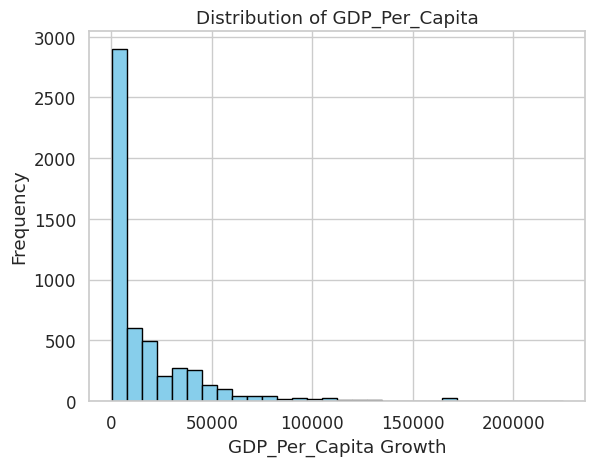

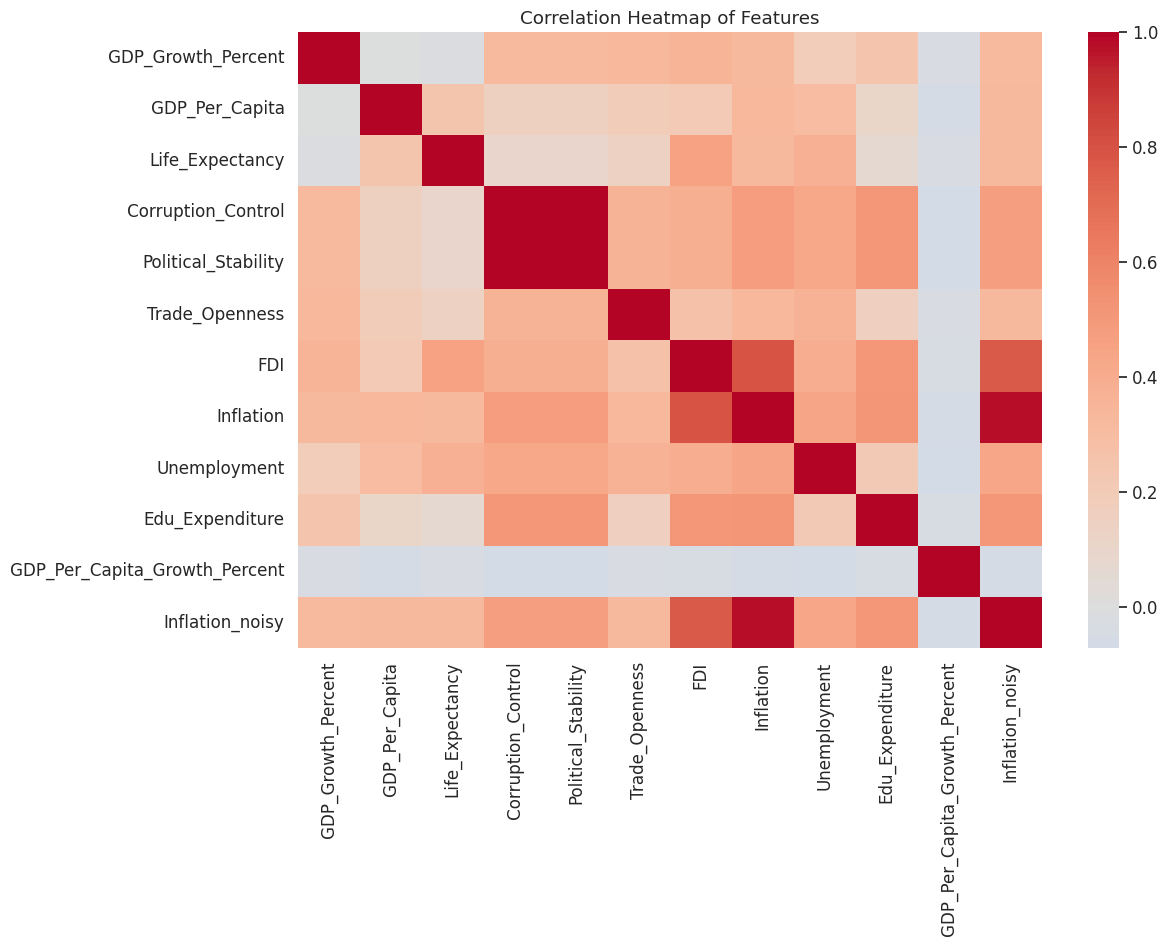

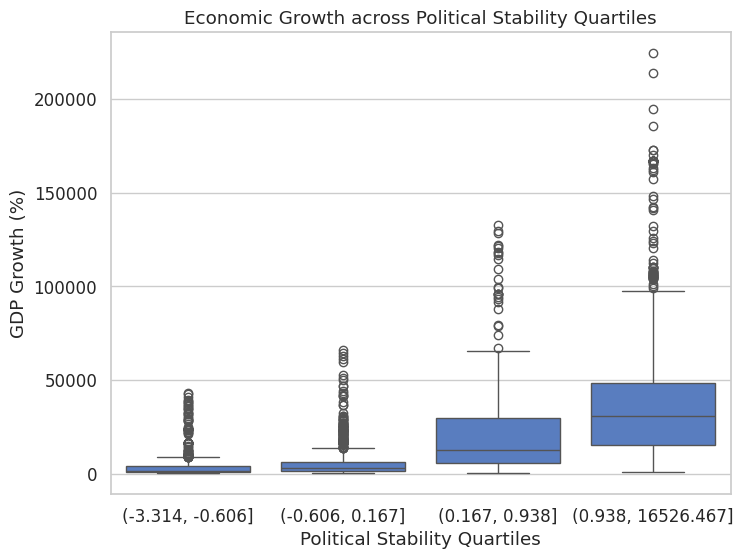

In [ ]:
# ======================
# 4. Noise Injection & Cleaning
# ======================

# Add Gaussian noise to Inflation (for robustness test)
if "Inflation" in df.columns:
    df['Inflation_noisy'] = df['Inflation'] + np.random.normal(
        0, df['Inflation'].std() * 0.2, df.shape[0]
    )

# Outlier detection using Z-score on numeric features
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude 'Year' (time variable) from outlier detection
if "Year" in numeric_features:
    numeric_features.remove("Year")

z_scores = np.abs(zscore(df[numeric_features]))
df_clean = df[(z_scores < 3).all(axis=1)]

print("Original shape:", df.shape, "| After cleaning:", df_clean.shape)

# ======================
# 5. Statistical Analysis
# ======================

print("\n=== Dataset Summary Statistics ===")
print(df.describe())

# Histogram of GDP Growth Percent
if "GDP_Per_Capita" in df.columns:
    plt.hist(df['GDP_Per_Capita'], bins=30, color="skyblue", edgecolor="black")
    plt.title("Distribution of GDP_Per_Capita")
    plt.xlabel("GDP_Per_Capita Growth")
    plt.ylabel("Frequency")
    plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_features].corr(), cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap of Features")
plt.show()

# Boxplot: Political Stability vs GDP_Per_Capita
if "Political_Stability" in df.columns and "GDP_Per_Capita" in df.columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(
        x=pd.qcut(df['Political_Stability'], 4, duplicates="drop"),
        y=df['GDP_Per_Capita']
    )
    plt.title("Economic Growth across Political Stability Quartiles")
    plt.xlabel("Political Stability Quartiles")
    plt.ylabel("GDP Growth (%)")
    plt.show()


Train years: [np.int64(2000), np.int64(2001), np.int64(2002), np.int64(2003), np.int64(2004), np.int64(2005), np.int64(2006), np.int64(2007), np.int64(2008), np.int64(2009), np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018)]
Test years: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]

=== Time-Based Validation Results (Forecasting) ===


,Model,RMSE,R²
0,Linear Regression,1675.046366,0.246417
1,Decision Tree,1327.170475,0.526924
2,Random Forest,1149.932681,0.644842
3,Gradient Boosting,914.518130,0.775373
4,Support Vector Regressor,1941.691886,-0.012600


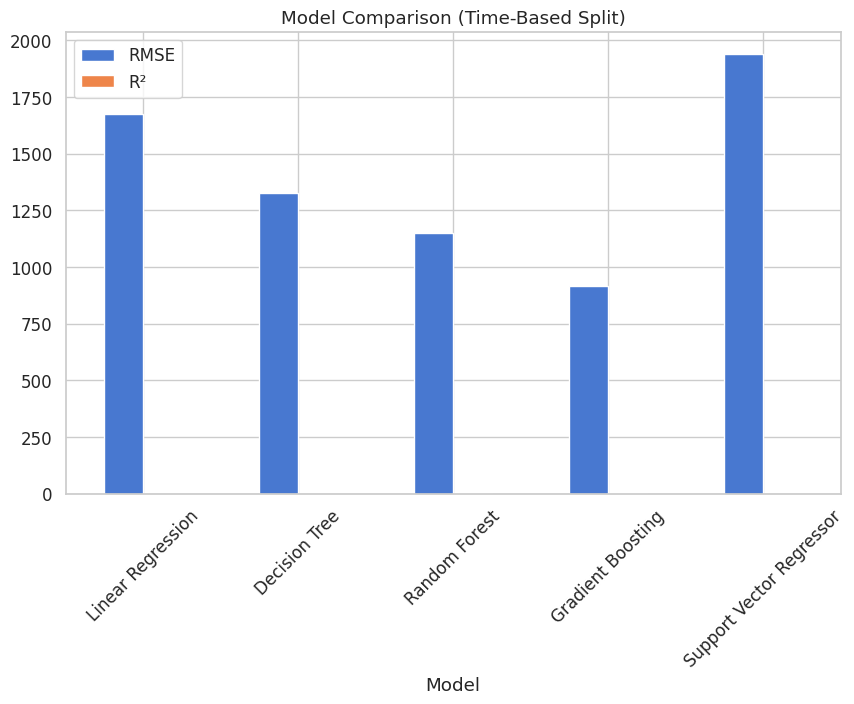

In [ ]:
# ======================
# 6.1 Supervised Learning - Regression Models
# ======================
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# ==== Define target and numeric features ====
target_col = "GDP_Growth_Percent"

# Keep only numeric columns, drop target + Year
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in feature_cols if col not in [target_col, "Year"]]

# ==== Time-based split (train ≤ 2018, test > 2018) ====
train = df[df["Year"] <= 2018].copy()
test  = df[df["Year"] > 2018].copy()

print("Train years:", sorted(train["Year"].unique()))
print("Test years:", sorted(test["Year"].unique()))

# ==== Features and target ====
X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test   = test[feature_cols], test[target_col]

# ==== Drop rows with missing values (important for pct_change features) ====
train_valid = pd.concat([X_train, y_train], axis=1).dropna()
test_valid  = pd.concat([X_test, y_test], axis=1).dropna()

X_train, y_train = train_valid[feature_cols], train_valid[target_col]
X_test, y_test   = test_valid[feature_cols], test_valid[target_col]

# ==== Scale features ====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ==== Models to compare ====
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR()
}

# ==== Evaluate models ====
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    results.append({"Model": name, "RMSE": rmse, "R²": r2})

# ==== Results DataFrame ====
time_val_results = pd.DataFrame(results)
print("\n=== Time-Based Validation Results (Forecasting) ===")
display(time_val_results)

# ==== Plot comparison ====
time_val_results.set_index("Model")[["RMSE","R²"]].plot(
    kind="bar", figsize=(10,6), title="Model Comparison (Time-Based Split)"
)
plt.xticks(rotation=45)
plt.show()


=== Time-Based Classification Model Comparison ===


,Model,Accuracy,F1,AUC
0,Logistic Regression,0.549309,0.394052,0.530723
1,Decision Tree,0.561290,0.513292,0.556948
2,Random Forest,0.631336,0.578059,0.670522
3,Gradient Boosting,0.605530,0.527594,0.636394
4,Support Vector Classifier,0.582488,0.503834,0.578305


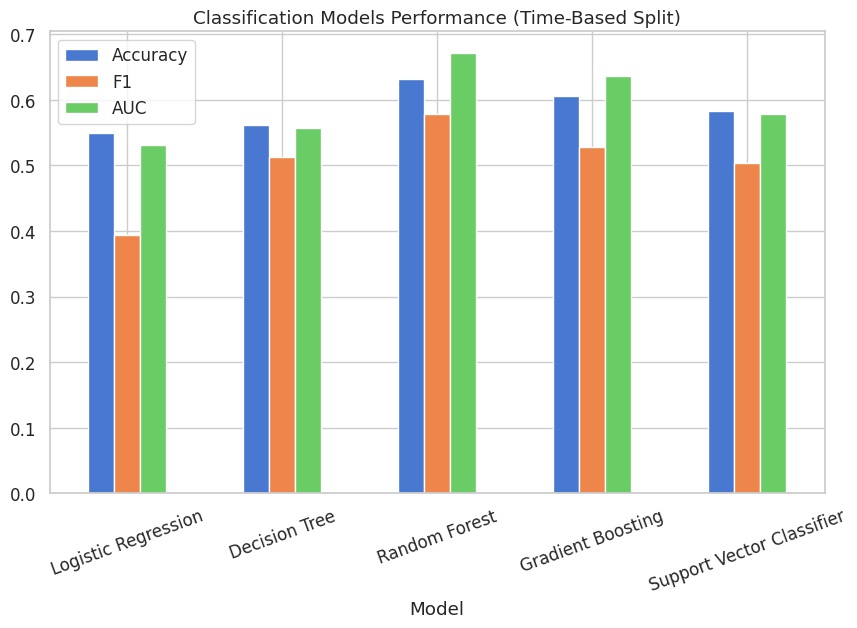

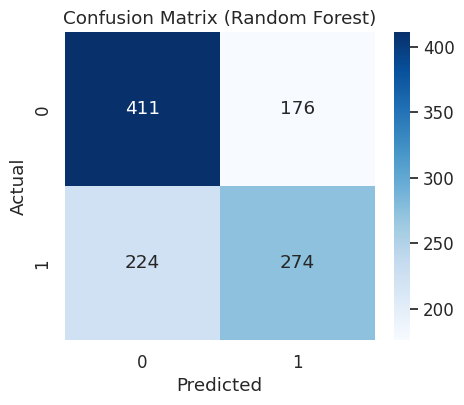

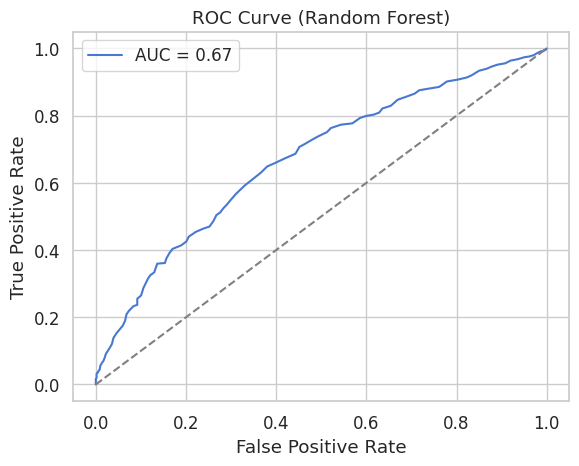

In [ ]:
# ======================
# 6.2 Supervised Learning - Classification Model Comparison
# ======================

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

# Encode categorical features
categorical_features = ["Country_Name", "Income_Group", "Region"]
df_enc = df.copy()
for col in categorical_features:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))

# Binary target: High vs Low GDP Growth
median_growth = df_enc["GDP_Growth_Percent"].median()
df_enc["Growth_Class"] = (df_enc["GDP_Growth_Percent"] > median_growth).astype(int)

# Features (drop targets)
X_class = df_enc.drop(columns=["GDP_Growth_Percent", "GDP_Per_Capita_Growth_Percent", "Growth_Class"])
y_class = df_enc["Growth_Class"]

# Scale numeric features
scaler = StandardScaler()
X_class_scaled = scaler.fit_transform(X_class)

# Time-based split (train ≤ 2018, test ≥ 2019)
train_mask = df_enc["Year"] <= 2018
test_mask = df_enc["Year"] > 2018

X_train, X_test = X_class_scaled[train_mask], X_class_scaled[test_mask]
y_train, y_test = y_class[train_mask], y_class[test_mask]

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Support Vector Classifier": SVC(probability=True, random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob)
    })

# Summary table
classification_summary = pd.DataFrame(results)
print("\n=== Time-Based Classification Model Comparison ===")
display(classification_summary)

# Bar plot
classification_summary.set_index("Model")[["Accuracy", "F1", "AUC"]].plot(
    kind="bar", figsize=(10,6), title="Classification Models Performance (Time-Based Split)"
)
plt.xticks(rotation=20)
plt.show()

# ======================
# Detailed Results for Best Model (Random Forest)
# ======================

rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--',color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.legend()
plt.show()


=== Unsupervised Learning Model Comparison ===
           Model  Silhouette Score
0         KMeans          0.686195
1  Agglomerative          0.646401
2            GMM          0.619528
3         DBSCAN               NaN

 Best Model: KMeans with Silhouette Score = 0.686

=== Cluster Profiles (Mean Values of Key Features - Original Scale) ===


,GDP_Per_Capita,Life_Expectancy,Inflation,Unemployment
Cluster_KMeans,,,,
0,13612.093528,70.361133,599.885434,1278.603635
1,39461.537249,76.125845,13610.361442,9725.834475
2,56176.925649,16526.466920,13221.500207,16526.466920


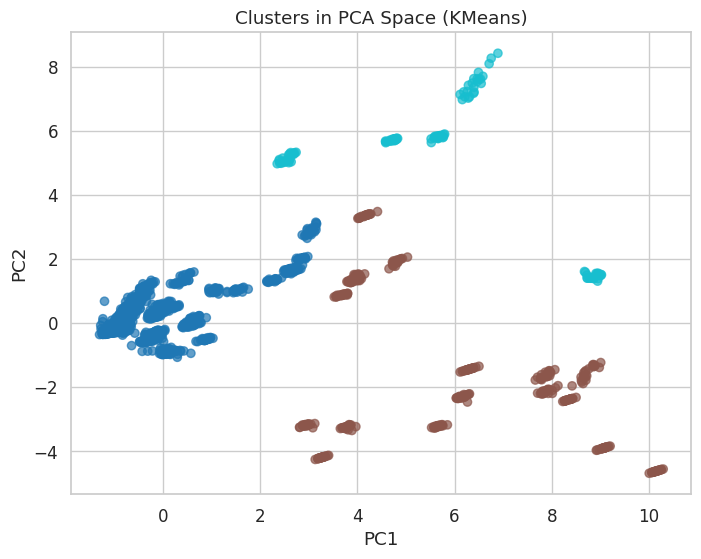

In [ ]:
# ======================
# 7. Unsupervised Learning with One-Hot Encoding
# ======================

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Step 1: One-Hot Encode categorical features ---
categorical_features = ["Country_Name", "Income_Group", "Region"]
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# --- Step 2: Prepare numeric data ---
X_unsup = df_encoded.select_dtypes(include=[np.number]).drop(columns=["Year"], errors="ignore")

# Drop rows with NaN (important for clustering)
X_unsup = X_unsup.dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsup)

# --- Step 3: Compare Clustering Models ---
cluster_results = []

# KMeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
sil_kmeans = silhouette_score(X_scaled, kmeans.labels_)
cluster_results.append(("KMeans", sil_kmeans))
X_unsup["Cluster_KMeans"] = kmeans.labels_

# Agglomerative
agg = AgglomerativeClustering(n_clusters=3).fit(X_scaled)
sil_agg = silhouette_score(X_scaled, agg.labels_)
cluster_results.append(("Agglomerative", sil_agg))
X_unsup["Cluster_Agglo"] = agg.labels_

# GMM
gmm = GaussianMixture(n_components=3, random_state=42).fit(X_scaled)
gmm_labels = gmm.predict(X_scaled)
sil_gmm = silhouette_score(X_scaled, gmm_labels)
cluster_results.append(("GMM", sil_gmm))
X_unsup["Cluster_GMM"] = gmm_labels

# DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=5).fit(X_scaled)
if len(set(dbscan.labels_)) > 1 and -1 not in set(dbscan.labels_):
    sil_db = silhouette_score(X_scaled, dbscan.labels_)
    cluster_results.append(("DBSCAN", sil_db))
    X_unsup["Cluster_DBSCAN"] = dbscan.labels_
else:
    cluster_results.append(("DBSCAN", np.nan))

# Results
cluster_results_df = pd.DataFrame(cluster_results, columns=["Model", "Silhouette Score"])
print("\n=== Unsupervised Learning Model Comparison ===")
print(cluster_results_df)

# Pick Best
best_model = cluster_results_df.sort_values("Silhouette Score", ascending=False).iloc[0]
print(f"\n Best Model: {best_model['Model']} with Silhouette Score = {best_model['Silhouette Score']:.3f}")

# --- Step 4: Apply Best Model ---
if best_model["Model"] == "KMeans":
    labels = X_unsup["Cluster_KMeans"]
elif best_model["Model"] == "Agglomerative":
    labels = X_unsup["Cluster_Agglo"]
elif best_model["Model"] == "GMM":
    labels = X_unsup["Cluster_GMM"]
else:
    labels = X_unsup.get("Cluster_DBSCAN", np.nan)

X_unsup["Cluster"] = labels

# --- Step 5: Cluster Profiling (Original Scale) ---
cluster_profiles = df.loc[X_unsup.index].groupby(labels)[
    ["GDP_Per_Capita", "Life_Expectancy", "Inflation", "Unemployment"]
].mean()

print("\n=== Cluster Profiles (Mean Values of Key Features - Original Scale) ===")
display(cluster_profiles)

# --- Step 6: PCA Visualization ---
pca = PCA(2)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(pc[:,0], pc[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Clusters in PCA Space ({best_model['Model']})")
plt.show()

INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktw679rw/z52folji.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktw679rw/sd43j54c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76732', 'data', 'file=/tmp/tmpktw679rw/z52folji.json', 'init=/tmp/tmpktw679rw/sd43j54c.json', 'output', 'file=/tmp/tmpktw679rw/prophet_modelp2_2ygf9/prophet_model-20250930195509.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:55:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:55:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpktw679rw/gelvd0q3.json
DEBUG:cmdstanpy:input tempfi


=== 2024: World Bank Actual vs ML (GB) vs Prophet ===
      Country  Year  WB Actual  ML (Gradient Boosting)  Prophet Forecast GDP Growth %  Closeness_ML (%)  Closeness_Prophet (%) Closer Model
        India  2024        6.5                    7.17                           5.14             89.63                  79.02      ML (GB)
        China  2024        5.0                    5.29                           4.71             94.10                  94.15      Prophet
    Indonesia  2024        5.0                    4.11                           3.36             82.25                  67.29      ML (GB)
United States  2024        2.8                    2.31                           1.84             82.55                  65.83      ML (GB)

=== Future (2025, 2026, 2030): IMF vs ML (GB) vs Prophet ===
      Country  Year  IMF Forecast  ML (Gradient Boosting)  Prophet Forecast GDP Growth %  Closeness_ML (%)  Closeness_Prophet (%) Closer Model
        India  2025           6.2       

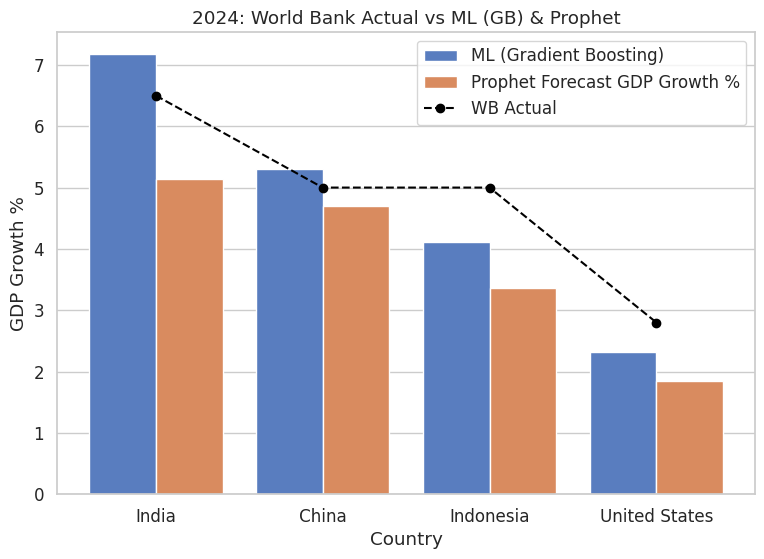

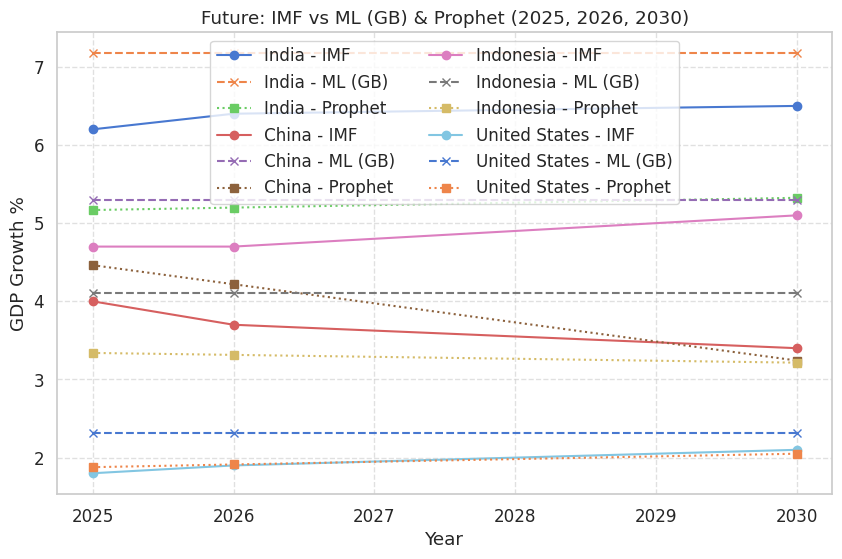

In [ ]:
# ======================
# Forecasts with Gradient Boosting (clean inputs + lag) vs Prophet
# WB actuals for 2024 and IMF for 2025/26/30
# ======================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from prophet import Prophet

# ----------------------
# 0) Config
# ----------------------
target_col = "GDP_Growth_Percent"
country_col = "Country_Name"
year_col = "Year"
target_countries = ["India", "China", "Indonesia", "United States"]
future_years = list(range(2024, 2031))  # 2024–2030 inclusive

# ----------------------
# 1) Clean unrealistic values → NaN, then impute
#    (These bounds are conservative and keep typical macro ranges.)
# ----------------------
df_fc = df.copy()

bounds = {
    "GDP_Growth_Percent": (-20, 20),
    "GDP_Per_Capita_Growth_Percent": (-50, 50),
    "Life_Expectancy": (40, 90),
    "Corruption_Control": (-3, 3),
    "Political_Stability": (-3, 3),
    "Trade_Openness": (0, 300),
    "FDI": (-50, 50),
    "Inflation": (-20, 100),
    "Unemployment": (0, 60),
    "Edu_Expenditure": (0, 20),
}

for col, (lo, hi) in bounds.items():
    if col in df_fc.columns:
        df_fc[col] = df_fc[col].where(df_fc[col].between(lo, hi), np.nan)

# Add a stable scale feature (log GDP per capita)
if "GDP_Per_Capita" in df_fc.columns:
    df_fc["Log_GDP_Per_Capita"] = np.log1p(df_fc["GDP_Per_Capita"])
else:
    df_fc["Log_GDP_Per_Capita"] = np.nan

# ----------------------
# 2) Add lag feature (t-1 GDP growth) per country
# ----------------------
df_fc = df_fc.sort_values([country_col, year_col])
df_fc["y_lag1"] = df_fc.groupby(country_col)[target_col].shift(1)

# ----------------------
# 3) Choose feature set (avoid columns that blow up / leak)
# ----------------------
feature_cols = [
    "GDP_Per_Capita_Growth_Percent",
    "Inflation",
    "Unemployment",
    "Trade_Openness",
    "FDI",
    "Corruption_Control",
    "Political_Stability",
    "Edu_Expenditure",
    "Log_GDP_Per_Capita",
    "y_lag1",
]

# Keep only available columns
feature_cols = [c for c in feature_cols if c in df_fc.columns]

# ----------------------
# 4) Build training matrix (use all historical years up to 2023)
# ----------------------
train_mask = df_fc[year_col] <= df_fc[year_col].max()
train_df = df_fc.loc[train_mask, [country_col, year_col, target_col] + feature_cols].copy()

# Drop rows with missing target
train_df = train_df.dropna(subset=[target_col])

X_raw = train_df[feature_cols].copy()
y = train_df[target_col].copy()

# Impute + scale features
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_raw)

scaler = StandardScaler()
X = scaler.fit_transform(X_imp)

# ----------------------
# 5) Train Gradient Boosting
# ----------------------
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X, y)

# ----------------------
# 6) Iterative ML forecasts per country (2024–2030)
#    - Hold macro features at last observed (or with tiny jitter)
#    - Roll forward y_lag1 with prior prediction
# ----------------------
ml_forecasts = []

for c in target_countries:
    hist_c = df_fc[df_fc[country_col] == c].sort_values(year_col).copy()
    if hist_c.empty:
        continue

    # Take last available row (2023 most likely)
    last_row = hist_c.iloc[-1]

    # Prepare a dict of features for rolling years
    state = {k: last_row.get(k, np.nan) for k in feature_cols}

    # Ensure lag starts from last observed target
    last_y = last_row.get(target_col, np.nan)
    if np.isnan(last_y):
        # fallback: use country median as lag if last y is missing
        last_y = hist_c[target_col].median()
    state["y_lag1"] = last_y

    for yr in future_years:
        # Keep macro features constant at last obs (optionally tiny jitter)
        # state[...] already has last obs
        # Build row in correct column order
        row_vec = [state.get(col, np.nan) for col in feature_cols]

        # Impute + scale like training
        row_imp = imputer.transform(pd.DataFrame([row_vec], columns=feature_cols))
        row_scaled = scaler.transform(row_imp)

        # Predict
        y_hat = gb.predict(row_scaled)[0]
        ml_forecasts.append([c, yr, y_hat])

        # Roll forward lag for next year
        state["y_lag1"] = y_hat

ml_forecast_df = pd.DataFrame(ml_forecasts, columns=["Country", "Year", "ML (Gradient Boosting)"])

# ----------------------
# 7) Prophet forecasts (per-country univariate)
# ----------------------
prophet_rows = []
for c in target_countries:
    sub = df_fc[df_fc[country_col] == c][[year_col, target_col]].dropna()
    if sub.empty:
        continue
    sub = sub.rename(columns={year_col: "ds", target_col: "y"})
    sub["ds"] = pd.to_datetime(sub["ds"], format="%Y")

    m = Prophet(yearly_seasonality=False, daily_seasonality=False, weekly_seasonality=False)
    m.fit(sub)

    future = pd.DataFrame({"ds": pd.to_datetime(future_years, format="%Y")})
    f = m.predict(future)[["ds", "yhat"]]
    f["Country"] = c
    f = f.rename(columns={"ds": "Year", "yhat": "Prophet Forecast GDP Growth %"})
    f["Year"] = f["Year"].dt.year
    prophet_rows.append(f)

prophet_forecast_df = pd.concat(prophet_rows, ignore_index=True) if prophet_rows else pd.DataFrame(columns=["Country","Year","Prophet Forecast GDP Growth %"])

# Merge
final_cmp = ml_forecast_df.merge(prophet_forecast_df, on=["Country","Year"], how="outer")

# ----------------------
# 8) 2024: Compare to World Bank actuals
# ----------------------
wb_data = [
    ("India", 2024, 6.5),
    ("China", 2024, 5.0),
    ("Indonesia", 2024, 5.0),
    ("United States", 2024, 2.8),
]
wb_df = pd.DataFrame(wb_data, columns=["Country","Year","WB Actual"])

cmp_2024 = wb_df.merge(final_cmp, on=["Country","Year"], how="left")

# Closeness %
cmp_2024["AE_ML"] = (cmp_2024["ML (Gradient Boosting)"] - cmp_2024["WB Actual"]).abs()
cmp_2024["AE_Prophet"] = (cmp_2024["Prophet Forecast GDP Growth %"] - cmp_2024["WB Actual"]).abs()

den_wb = cmp_2024["WB Actual"].replace(0, np.nan)
cmp_2024["Closeness_ML (%)"] = (1 - cmp_2024["AE_ML"]/den_wb) * 100
cmp_2024["Closeness_Prophet (%)"] = (1 - cmp_2024["AE_Prophet"]/den_wb) * 100
cmp_2024[["Closeness_ML (%)","Closeness_Prophet (%)"]] = cmp_2024[["Closeness_ML (%)","Closeness_Prophet (%)"]].clip(lower=0, upper=100)

cmp_2024["Closer Model"] = np.where(cmp_2024["AE_ML"] < cmp_2024["AE_Prophet"], "ML (GB)", "Prophet")

print("\n=== 2024: World Bank Actual vs ML (GB) vs Prophet ===")
print(cmp_2024[[
    "Country","Year","WB Actual","ML (Gradient Boosting)","Prophet Forecast GDP Growth %",
    "Closeness_ML (%)","Closeness_Prophet (%)","Closer Model"
]].round(2).to_string(index=False))

# ----------------------
# 9) Future: Compare to IMF (2025, 2026, 2030)
# ----------------------
imf_data = [
    ("India", 2025, 6.2), ("India", 2026, 6.4), ("India", 2030, 6.5),
    ("China", 2025, 4.0), ("China", 2026, 3.7), ("China", 2030, 3.4),
    ("Indonesia", 2025, 4.7), ("Indonesia", 2026, 4.7), ("Indonesia", 2030, 5.1),
    ("United States", 2025, 1.8), ("United States", 2026, 1.9), ("United States", 2030, 2.1),
]
imf_df = pd.DataFrame(imf_data, columns=["Country","Year","IMF Forecast"])

cmp_future = imf_df.merge(final_cmp, on=["Country","Year"], how="left")

cmp_future["AE_ML"] = (cmp_future["ML (Gradient Boosting)"] - cmp_future["IMF Forecast"]).abs()
cmp_future["AE_Prophet"] = (cmp_future["Prophet Forecast GDP Growth %"] - cmp_future["IMF Forecast"]).abs()

den_imf = cmp_future["IMF Forecast"].replace(0, np.nan)
cmp_future["Closeness_ML (%)"] = (1 - cmp_future["AE_ML"]/den_imf) * 100
cmp_future["Closeness_Prophet (%)"] = (1 - cmp_future["AE_Prophet"]/den_imf) * 100
cmp_future[["Closeness_ML (%)","Closeness_Prophet (%)"]] = cmp_future[["Closeness_ML (%)","Closeness_Prophet (%)"]].clip(lower=0, upper=100)

cmp_future["Closer Model"] = np.where(cmp_future["AE_ML"] < cmp_future["AE_Prophet"], "ML (GB)", "Prophet")

print("\n=== Future (2025, 2026, 2030): IMF vs ML (GB) vs Prophet ===")
print(cmp_future[[
    "Country","Year","IMF Forecast","ML (Gradient Boosting)","Prophet Forecast GDP Growth %",
    "Closeness_ML (%)","Closeness_Prophet (%)","Closer Model"
]].round(2).to_string(index=False))

# ----------------------
# 10) Plots
# ----------------------
# 2024 bar chart
plt.figure(figsize=(9,6))
plot_2024 = cmp_2024.melt(
    id_vars=["Country","WB Actual"],
    value_vars=["ML (Gradient Boosting)","Prophet Forecast GDP Growth %"],
    var_name="Model", value_name="Prediction"
)
sns.barplot(data=plot_2024, x="Country", y="Prediction", hue="Model")
plt.plot(range(len(cmp_2024)), cmp_2024["WB Actual"], marker="o", linestyle="--", color="black", label="WB Actual")
plt.title("2024: World Bank Actual vs ML (GB) & Prophet")
plt.ylabel("GDP Growth %")
plt.legend()
plt.show()

# Future line chart
plt.figure(figsize=(10,6))
for c in cmp_future["Country"].unique():
    s = cmp_future[cmp_future["Country"] == c]
    plt.plot(s["Year"], s["IMF Forecast"], marker="o", label=f"{c} - IMF")
    plt.plot(s["Year"], s["ML (Gradient Boosting)"], marker="x", linestyle="--", label=f"{c} - ML (GB)")
    plt.plot(s["Year"], s["Prophet Forecast GDP Growth %"], marker="s", linestyle=":", label=f"{c} - Prophet")
plt.title("Future: IMF vs ML (GB) & Prophet (2025, 2026, 2030)")
plt.xlabel("Year"); plt.ylabel("GDP Growth %"); plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(ncol=2)
plt.show()
